In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from typing import List
matplotlib.use('nbagg')

%matplotlib inline

## Mount Google Drive

Remove this section if you are uploading files manually.

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Specify filename

In [168]:
filename = "drive/MyDrive/sacc.adapt.data/IG.100.lag.asc"

### Load eyelink data

In [169]:
# read eyelink data from asc file
with open(filename, 'r') as f:
    data = f.readlines()
# extract sampling parameters
DISPLAY_COORDS = list(map(float,[x[:-1].split(' ') for x in data if 'DISPLAY_COORDS' in x][0][-2:]))
RETRACE_INTERVAL = float([x[:-1].split(' ') for x in data if 'RETRACE_INTERVAL' in x][0][-1:][0])
SAMPLE_RATE = float([x[:-1].split('\t') for x in data if 'RATE' in x and x.startswith('SAMPLES')][0][4])
# extract trial parameters
START = np.array([int(x[:-1].split('\t')[1]) for x in data if x.startswith('START')], 'int')
END = np.array([int(x[:-1].split('\t')[1]) for x in data if x.startswith('END')], 'int')
assert len(START)==len(END)
TRIALID = [int(x.strip().split(' ')[-1]) for x in data if 'TRIALID' in x]
BLOCK = [int(x.strip().split(' ')[-1]) for x in data if 'TRIAL_VAR block' in x]
RECYCLED = [x.strip().split(' ')[-1] == "True" for x in data if 'TRIAL_VAR Trial_Recycled_' in x]
RECAL = [x.strip().split(' ')[-1] == "True" for x in data if 'TRIAL_VAR Recal' in x]
TARGPOS = [int(x.strip().split(' ')[-1]) for x in data if 'TRIAL_VAR targpos' in x]
STEPPOS = [int(x.strip().split(' ')[-1]) for x in data if 'TRIAL_VAR steppos' in x]
DUR = END-START
# Target position shifts (can occur multiple times in a trial)
TARGET_POS = [list(map(int,x[:-1].split(' ')[4][1:-1].split(','))) for x in data if 'TARGET_POS' in x]
TARGET_POS_SAMPLE = [int(x.split(' ')[0].split('\t')[1]) for x in data if 'TARGET_POS' in x]
assert len(TARGET_POS) == len(TARGET_POS_SAMPLE)
TARGETS=[]
tpos = np.array(TARGET_POS, 'int')
tsample = np.array(TARGET_POS_SAMPLE, 'int')
for start, end in zip(START, END):
  indices = np.array((np.greater_equal(tsample, start) & np.less_equal(tsample, end)).nonzero()[0], 'int')
  TARGETS.append(tuple(zip(tsample[indices], tpos[indices])))
# Form trial dataframe
trial = pd.DataFrame(
    data = {
        "TrialID": TRIALID,
        "BlockNo": BLOCK,
        "Recycled": RECYCLED,
        "Recal": RECAL,
        "TargetPos": TARGPOS,
        "StepPos": STEPPOS,
        "StartPos": START,
        "EndPos": END,
        "Duration": DUR,
        "Targets": TARGETS,
    }
  )
# isolate lines denoting eye position (those ending with ellipses)
data = [line[:-4] for line in data if line[-4:] == '...\n']
# convert list[str] to numpy matrix
data = np.genfromtxt(
    data,
    delimiter='\t',
    usecols=range(5),
    missing_values='.',
    filling_values=np.nan,
    dtype=float
)
# scale data to sampling parameters
xtrans = lambda x: 2*(x/DISPLAY_COORDS[0] - 0.5)
ytrans = lambda x: 2*(x/DISPLAY_COORDS[1] - 0.5)
data[:,1] = xtrans(data[:,1])
data[:,2] = ytrans(data[:,2])
TARGET_POS = [[xtrans(x), ytrans(y)] for x, y in TARGET_POS]
# labels
channel_label = [
    'sample',
    'x-pos (norm)',
    'y-pos (norm)',
    'pupil (raw)',
    'constant',
]

# convert to pandas dataframe
df = pd.DataFrame(data[:,:-1], columns = channel_label[:-1])
# fill-in missing samples (aligns samples to indices)
df['sample'] = df['sample'].astype('int')
new_index = pd.Index(np.arange(df['sample'].iloc[0],df['sample'].iloc[-1]), name="sample")
df = df.set_index("sample").reindex(new_index).reset_index()
# zero starting sample
FIRST_SAMPLE = df['sample'].iloc[0]
START = START - FIRST_SAMPLE
END = END - FIRST_SAMPLE
df['sample'] = df['sample']-FIRST_SAMPLE
# samples to time
channel_label[0] = 'Time (msecs)'
df[channel_label[0]] = df['sample']*1000/SAMPLE_RATE  # msecs
df = df.drop('sample', axis=1)

# Remove relcalibation trials
print("Trials before rejection: ", len(trial))
trial=trial[trial["Recal"] == False]
trial = trial.reset_index(drop=True)
print("Trials after rejection: ", len(trial))

print(df)

Trials before rejection:  248
Trials after rejection:  210
        x-pos (norm)  y-pos (norm)  pupil (raw)  Time (msecs)
0          -0.147264     -0.016126        799.0           0.0
1          -0.146743     -0.015014        800.0           1.0
2          -0.146743     -0.013902        800.0           2.0
3          -0.147160     -0.013716        799.0           3.0
4          -0.147994     -0.014087        799.0           4.0
...              ...           ...          ...           ...
939437      0.625221      0.028545       1927.0      939437.0
939438      0.625117      0.028545       1927.0      939438.0
939439      0.625013      0.028730       1926.0      939439.0
939440      0.624909      0.030028       1926.0      939440.0
939441      0.624909      0.031325       1925.0      939441.0

[939442 rows x 4 columns]


### Examine channel data

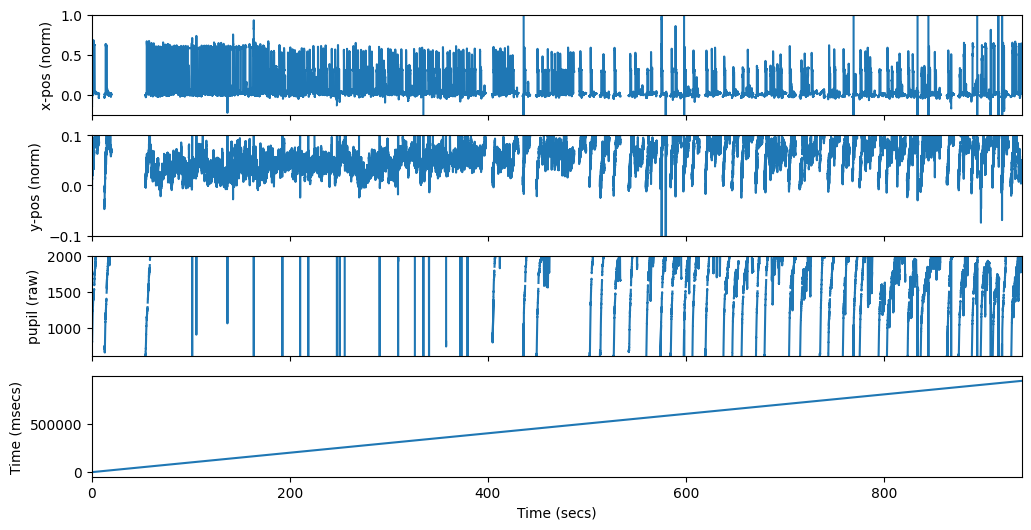

In [170]:
time_secs = df['Time (msecs)']/1000
fig, axs = plt.subplots(len(df.columns), figsize=(12, 6), sharex=True)
for k, colname in enumerate(df.columns):
    axs[k].plot(time_secs, df[colname])
    axs[k].set_ylabel(colname)
axs[0].set_xlim(time_secs.iloc[0], time_secs.iloc[-1])

axs[0].set_ylim(-0.25, 1.0)
axs[1].set_ylim(-0.1, 0.1)
axs[2].set_ylim(600, 2000)
axs[3].set_xlabel('Time (secs)')
fig.show()

### xy-trace

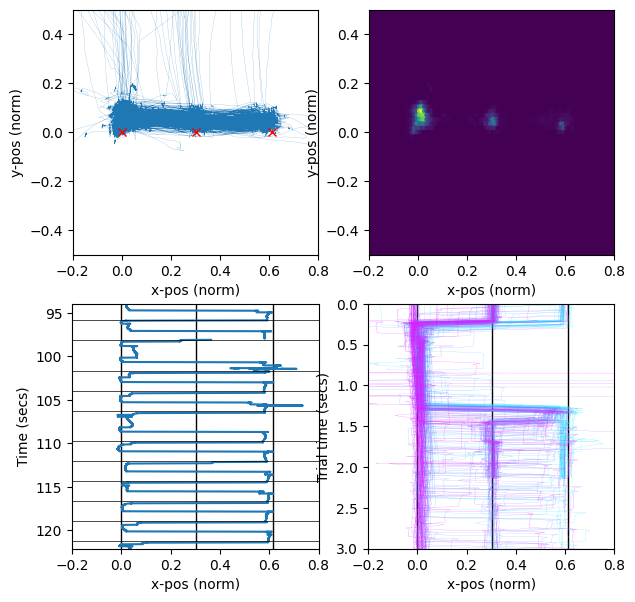

In [171]:
chx, chy = 'x-pos (norm)', 'y-pos (norm)'  # x, y

fig, axs = plt.subplot_mosaic(
    [['b','c'], ['a','d']],
    figsize=(7, 7),
)

# temporal segment
for x, y in np.unique(np.array(TARGET_POS), axis=0):
  axs['a'].plot(np.array([x, x]), [time_secs.iloc[0], time_secs.iloc[-1]], 'k-', linewidth=1)
axs['a'].plot(df[chx], time_secs)
for start, end in zip(START, END):
  axs['a'].plot(np.array([-1, 1]), np.array([start, start])/SAMPLE_RATE, 'k-', linewidth=0.5)
axs['a'].set_xlim(-0.2, 0.8)
axs['a'].set_xlabel(chx)
axs['a'].set_ylabel('Time (secs)')
axs['a'].set_ylim(
    time_secs.iloc[round(0.100*len(time_secs))],
    time_secs.iloc[round(0.130*len(time_secs))],
)
axs['a'].invert_yaxis()

# xy-trace
axs['b'].plot(df[chx], df[chy], linewidth=0.1)
for x, y in np.unique(np.array(TARGET_POS), axis=0):
  axs['b'].plot(x, y, 'rx')
axs['b'].set_aspect('equal', 'box')
axs['b'].set_xlim(-0.2, 0.8)
axs['b'].set_ylim(-0.5, 0.5)
axs['b'].set_xlabel(chx)
axs['b'].set_ylabel(chy)

# spatial histogram
axs['c'].hexbin(
    df[chx],
    df[chy],
    extent=(-0.2, 0.8, -0.5, 0.5),
)
axs['c'].set_aspect('equal', 'box')
axs['c'].set_xlim(-0.2, 0.8)
axs['c'].set_ylim(-0.5, 0.5)
axs['c'].set_xlabel(chx)
axs['c'].set_ylabel(chy)

# stack trials
for x, y in np.unique(np.array(TARGET_POS), axis=0):
  axs['d'].plot(np.array([x, x]), np.array([0.0, 3.0]), 'k-', linewidth=1)
viridis = matplotlib.colormaps['cool']
for index, (start, end) in enumerate(zip(START, END)):
  axs['d'].plot(
      df[chx].iloc[start:end],
      time_secs.iloc[start:end]-time_secs.iloc[start],
      '-',
      linewidth=0.1,
      color=viridis(index/(len(START)-1)),
  )
axs['d'].set_ylabel('Trial time (secs)')
axs['d'].set_xlabel(chx)
axs['d'].set_xlim(-0.2, 0.8)
axs['d'].set_ylim(0, 3)
axs['d'].invert_yaxis()

fig.show()

## Extract per-trial metrics

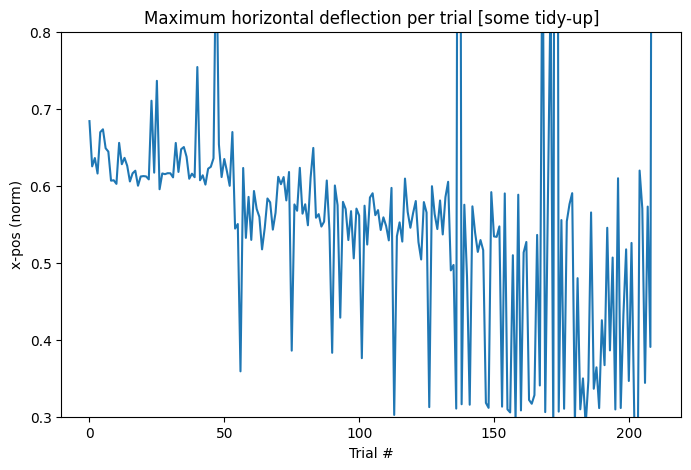

In [172]:
# Loop over trials
trial['max_x'] = [0]*len(trial)
for index, (start, end) in enumerate(zip(START, END)):
  trial['max_x'].at[index] = max(df[chx].iloc[start:end])

# Plot metric
data = trial['max_x']
# data[data>0.8] = None  # Remove obvious outliers (for now)

fig, axs = plt.subplots(1, figsize=(8, 5), sharex=True)
axs.plot(data)
axs.set_ylim([0.3, 0.8])
axs.set_ylabel(chx)
axs.set_xlabel("Trial #")
axs.set_title("Maximum horizontal deflection per trial [some tidy-up]")

fig.show()